In [18]:
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data
import pandas as pd
import numpy as np
from functools import partial
from matplotlib import pyplot as plt

# Linear AutoEncoder

In [2]:
n_inputs = 3  # 3D inputs
n_hidden = 2  # 2D codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))  # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [3]:
def simple_pca_encoder():
    n_inputs = 4
    n_hidden = 2
    n_outputs = n_inputs
    learning_rate = 0.01
    train_data = load_iris()
    x_train, x_test, y_train, y_test = train_test_split(train_data.data, train_data.target, test_size=0.2)
    with tf.variable_scope("pca"):
        x = tf.placeholder(tf.float32, shape=[None, n_inputs])
        hidden = tf.layers.dense(x, n_hidden)
        outputs = tf.layers.dense(hidden, n_outputs)
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - x))
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(reconstruction_loss)
        init = tf.global_variables_initializer()
        n_iterations = 100
        codings = hidden  # the output of the hidden layer provides the codings

        with tf.Session() as sess:
            init.run()
            for iteration in range(n_iterations):
                training_op.run(feed_dict={x: x_train})  # no labels (unsupervised)
            codings_val = codings.eval(feed_dict={x: x_test})
            print codings_val

simple_pca_encoder()        

[[ -7.01136887e-02  -5.57156801e+00]
 [ -7.60095417e-02  -6.42548370e+00]
 [  6.86446130e-02  -5.33880520e+00]
 [ -4.36715394e-01  -4.31246519e+00]
 [ -4.36334908e-02  -5.62303829e+00]
 [  2.31051534e-01  -6.05762768e+00]
 [  2.17960775e-02  -5.56724453e+00]
 [  1.38762683e-01  -6.56614590e+00]
 [  6.22105300e-02  -6.13975525e+00]
 [  1.65011972e-01  -6.43571663e+00]
 [ -3.13022435e-02  -6.87844563e+00]
 [ -6.33029580e-01  -4.75519466e+00]
 [ -5.02632141e-01  -4.27980709e+00]
 [  6.79392517e-02  -6.56091213e+00]
 [  4.84918058e-02  -6.80401039e+00]
 [  2.53900021e-01  -5.87086344e+00]
 [ -6.22523904e-01  -4.73083687e+00]
 [  1.68611139e-01  -6.12046194e+00]
 [ -4.41953629e-01  -4.39417934e+00]
 [  4.44807708e-02  -7.06997108e+00]
 [  5.20774722e-03  -5.39929295e+00]
 [  4.30414379e-02  -6.11484814e+00]
 [ -1.65432990e-02  -5.35221338e+00]
 [  1.40301883e-02  -6.00571918e+00]
 [  2.00728625e-01  -7.90731907e+00]
 [  1.21181577e-01  -6.81026649e+00]
 [ -1.05647177e-01  -4.73177195e+00]
 

# Stacked AutoEncoder

In [5]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01
l2_reg = 0.0001

In [7]:
mnist_path = "/Users/lgrcyanny/Codecookies/machine-learning-workspace/tensorflow-wp/datasets/mnist/"
mnist = input_data.read_data_sets(mnist_path, one_hot=True)
# tf.contrib.learn.datasets.load_dataset(name="mnist")

Extracting /Users/lgrcyanny/Codecookies/machine-learning-workspace/tensorflow-wp/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /Users/lgrcyanny/Codecookies/machine-learning-workspace/tensorflow-wp/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/lgrcyanny/Codecookies/machine-learning-workspace/tensorflow-wp/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/lgrcyanny/Codecookies/machine-learning-workspace/tensorflow-wp/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [23]:
with tf.name_scope("stacked_auto_encoder"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                             kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
    hidden1 = my_dense_layer(X, n_hidden1)
    hidden2 = my_dense_layer(hidden1, n_hidden2)
    hidden3 = my_dense_layer(hidden2, n_hidden3)
    outputs = my_dense_layer(hidden3, n_outputs, activation=None)
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
    reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([reconstruction_loss] + reg_loss)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    # training
    n_epochs = 5
    batch_size = 150
    
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = mnist.train.num_examples // batch_size
            for iteration in range(n_batches):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                op_v, loss_v = sess.run([training_op, loss], feed_dict={X: X_batch})
                print("loss", loss_v)

('loss', 1.2578225)
('loss', 1.0150056)
('loss', 0.84500217)
('loss', 0.71825343)
('loss', 0.63166672)
('loss', 0.56062055)
('loss', 0.50086397)
('loss', 0.45326072)
('loss', 0.41699326)
('loss', 0.38734487)
('loss', 0.36342579)
('loss', 0.34176308)
('loss', 0.32736832)
('loss', 0.31635529)
('loss', 0.30729151)
('loss', 0.29635012)
('loss', 0.28633505)
('loss', 0.28070951)
('loss', 0.27458113)
('loss', 0.27000332)
('loss', 0.26409131)
('loss', 0.26051331)
('loss', 0.25203335)
('loss', 0.24785332)
('loss', 0.24153163)
('loss', 0.23463988)
('loss', 0.23061702)
('loss', 0.22587174)
('loss', 0.22144747)
('loss', 0.21397203)
('loss', 0.21073136)
('loss', 0.2055162)
('loss', 0.1989014)
('loss', 0.19731797)
('loss', 0.19131164)
('loss', 0.18675959)
('loss', 0.18495369)
('loss', 0.17960796)
('loss', 0.17751378)
('loss', 0.17490679)
('loss', 0.16930604)
('loss', 0.16371903)
('loss', 0.16231345)
('loss', 0.16074754)
('loss', 0.15630813)
('loss', 0.15326534)
('loss', 0.14929944)
('loss', 0.148076

('loss', 0.03816767)
('loss', 0.035519157)
('loss', 0.037413709)
('loss', 0.035662886)
('loss', 0.036993988)
('loss', 0.036145084)
('loss', 0.038744491)
('loss', 0.036856383)
('loss', 0.035652597)
('loss', 0.037152465)
('loss', 0.036601976)
('loss', 0.037177615)
('loss', 0.037923139)
('loss', 0.036558792)
('loss', 0.036113515)
('loss', 0.035839297)
('loss', 0.037874676)
('loss', 0.038400646)
('loss', 0.037318721)
('loss', 0.038578007)
('loss', 0.035719182)
('loss', 0.034427024)
('loss', 0.03571007)
('loss', 0.037417788)
('loss', 0.038488664)
('loss', 0.037913822)
('loss', 0.03904222)
('loss', 0.037420664)
('loss', 0.036434647)
('loss', 0.035446331)
('loss', 0.03680592)
('loss', 0.03778046)
('loss', 0.035404101)
('loss', 0.035937823)
('loss', 0.035599563)
('loss', 0.03748158)
('loss', 0.036311746)
('loss', 0.036236651)
('loss', 0.036742236)
('loss', 0.037763473)
('loss', 0.037633702)
('loss', 0.036761962)
('loss', 0.037986189)
('loss', 0.035542384)
('loss', 0.03705053)
('loss', 0.037047

('loss', 0.035146609)
('loss', 0.03405489)
('loss', 0.034056667)
('loss', 0.032589838)
('loss', 0.036090098)
('loss', 0.034722298)
('loss', 0.033201203)
('loss', 0.033921272)
('loss', 0.034133855)
('loss', 0.033894505)
('loss', 0.033701524)
('loss', 0.035831563)
('loss', 0.034455109)
('loss', 0.035621028)
('loss', 0.03301743)
('loss', 0.033335488)
('loss', 0.032237783)
('loss', 0.034072068)
('loss', 0.034118779)
('loss', 0.035746794)
('loss', 0.033943877)
('loss', 0.034548488)
('loss', 0.034818653)
('loss', 0.033796951)
('loss', 0.034191974)
('loss', 0.033171728)
('loss', 0.033545181)
('loss', 0.035278883)
('loss', 0.032783568)
('loss', 0.033962145)
('loss', 0.033236682)
('loss', 0.033860359)
('loss', 0.034934659)
('loss', 0.034862746)
('loss', 0.033785623)
('loss', 0.033718459)
('loss', 0.034728229)
('loss', 0.033990216)
('loss', 0.033336841)
('loss', 0.032853007)
('loss', 0.032406934)
('loss', 0.034457136)
('loss', 0.033023749)
('loss', 0.03456353)
('loss', 0.034958344)
('loss', 0.03

('loss', 0.032025367)
('loss', 0.031832296)
('loss', 0.034316335)
('loss', 0.033316433)
('loss', 0.033486266)
('loss', 0.033651553)
('loss', 0.03332445)
('loss', 0.035103954)
('loss', 0.033141892)
('loss', 0.034778606)
('loss', 0.032976538)
('loss', 0.032369804)
('loss', 0.033989582)
('loss', 0.033604238)
('loss', 0.03359871)
('loss', 0.033559915)
('loss', 0.032508418)
('loss', 0.032883458)
('loss', 0.034841303)
('loss', 0.033436701)
('loss', 0.0333369)
('loss', 0.030764595)
('loss', 0.032818113)
('loss', 0.031961665)
('loss', 0.034814484)
('loss', 0.033040985)
('loss', 0.033200406)
('loss', 0.0328114)
('loss', 0.033584706)
('loss', 0.034673419)
('loss', 0.032901458)
('loss', 0.032473233)
('loss', 0.032386102)
('loss', 0.033225738)
('loss', 0.032490171)
('loss', 0.034798983)
('loss', 0.034881189)
('loss', 0.033943448)
('loss', 0.032883413)
('loss', 0.034290876)
('loss', 0.033547863)
('loss', 0.032228999)
('loss', 0.033482812)
('loss', 0.033055767)
('loss', 0.032734551)
('loss', 0.03240

('loss', 0.03230945)
('loss', 0.033854954)
('loss', 0.033630792)
('loss', 0.033080693)
('loss', 0.032351833)
('loss', 0.032550775)
('loss', 0.031088423)
('loss', 0.031632852)
('loss', 0.034230631)
('loss', 0.034186285)
('loss', 0.032061111)
('loss', 0.032836411)
('loss', 0.033685584)
('loss', 0.033945091)
('loss', 0.034729559)
('loss', 0.033241518)
('loss', 0.032632343)
('loss', 0.032661773)
('loss', 0.03248398)
('loss', 0.034811854)
('loss', 0.032223575)
('loss', 0.033695582)
('loss', 0.034608636)
('loss', 0.032894619)
('loss', 0.033954218)
('loss', 0.03280884)
('loss', 0.030161731)
('loss', 0.033123605)
('loss', 0.032491781)
('loss', 0.031688288)
('loss', 0.03359117)
('loss', 0.033155609)
('loss', 0.03335502)
('loss', 0.032357007)
('loss', 0.034113638)
('loss', 0.033456545)
('loss', 0.031323668)
('loss', 0.032660171)
('loss', 0.031725407)
('loss', 0.03195354)
('loss', 0.031471085)
('loss', 0.032968931)
('loss', 0.033191007)
('loss', 0.031650737)
('loss', 0.033827309)
('loss', 0.03264

# Trying Weights for Symmetric Autoencoders

In [6]:
n_inputs = 28 * 28  # for MNIST
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.01
l2_reg = 0.0001

In [24]:
with tf.name_scope("trying_weights"):
    activation = tf.nn.elu
    regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    initializer = tf.contrib.layers.variance_scaling_initializer()

    X = tf.placeholder(tf.float32, shape=[None, n_inputs])

    weights1_init = initializer([n_inputs, n_hidden1])
    weights2_init = initializer([n_hidden1, n_hidden2])

    weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
    weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
    weights3 = tf.transpose(weights2, name="weights3")  # tied weights
    weights4 = tf.transpose(weights1, name="weights4")  # tied weights

    biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
    biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
    biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
    biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

    hidden1 = activation(tf.matmul(X, weights1) + biases1)
    hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
    hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
    outputs = tf.matmul(hidden3, weights4) + biases4

    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
    reg_loss = regularizer(weights1) + regularizer(weights2)
    loss = reconstruction_loss + reg_loss

    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        n_epochs = 5
        batch_size = 150
        init.run()
        for epoch in range(n_epochs):
            n_batches = mnist.train.num_examples // batch_size
            for iteration in range(n_batches):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                op_v, loss_v = sess.run([training_op, loss], feed_dict={X: X_batch})
                print("loss", loss_v)
        # for visualize         
        outputs_val = outputs.eval(feed_dict={X: X_test})        

('loss', 0.26459944)
('loss', 1.9914695)
('loss', 1.077732)
('loss', 0.49570906)
('loss', 0.3920075)
('loss', 0.4622137)
('loss', 1.4279269)
('loss', 1.3371571)
('loss', 0.58609354)
('loss', 0.44170734)
('loss', 0.53744972)
('loss', 0.32833177)
('loss', 0.30553451)
('loss', 0.31219184)
('loss', 0.20385633)
('loss', 0.25732213)
('loss', 0.2137333)
('loss', 0.21394163)
('loss', 0.19899338)
('loss', 0.17850865)
('loss', 0.17948736)
('loss', 0.15783295)
('loss', 0.17739685)
('loss', 0.14998357)
('loss', 0.16813827)
('loss', 0.13804099)
('loss', 0.16026321)
('loss', 0.13675606)
('loss', 0.14455143)
('loss', 0.1290365)
('loss', 0.13368095)
('loss', 0.12389311)
('loss', 0.12550987)
('loss', 0.12507018)
('loss', 0.11844079)
('loss', 0.1182856)
('loss', 0.116699)
('loss', 0.11511233)
('loss', 0.112259)
('loss', 0.11105154)
('loss', 0.10984771)
('loss', 0.10960025)
('loss', 0.10978576)
('loss', 0.10638951)
('loss', 0.10669903)
('loss', 0.10260151)
('loss', 0.10277121)
('loss', 0.099014804)
('los

('loss', 0.032157283)
('loss', 0.032828979)
('loss', 0.032204933)
('loss', 0.032832999)
('loss', 0.032067288)
('loss', 0.031478468)
('loss', 0.031953171)
('loss', 0.032778762)
('loss', 0.031853363)
('loss', 0.031752124)
('loss', 0.031660981)
('loss', 0.031834915)
('loss', 0.032080173)
('loss', 0.031739376)
('loss', 0.031953752)
('loss', 0.032189377)
('loss', 0.031585719)
('loss', 0.0316789)
('loss', 0.031993791)
('loss', 0.031104013)
('loss', 0.031282943)
('loss', 0.031384211)
('loss', 0.031296983)
('loss', 0.030714493)
('loss', 0.03146698)
('loss', 0.031614024)
('loss', 0.030598808)
('loss', 0.030164722)
('loss', 0.030650569)
('loss', 0.03037994)
('loss', 0.030819414)
('loss', 0.030381873)
('loss', 0.03085269)
('loss', 0.03052241)
('loss', 0.030337228)
('loss', 0.030098263)
('loss', 0.030925404)
('loss', 0.029767754)
('loss', 0.030166809)
('loss', 0.030917242)
('loss', 0.030269152)
('loss', 0.030302869)
('loss', 0.030197307)
('loss', 0.029618999)
('loss', 0.029881943)
('loss', 0.02955

('loss', 0.019994617)
('loss', 0.020198215)
('loss', 0.02013159)
('loss', 0.020529114)
('loss', 0.019982696)
('loss', 0.020317903)
('loss', 0.020233829)
('loss', 0.020230837)
('loss', 0.019824725)
('loss', 0.020080268)
('loss', 0.020137275)
('loss', 0.020267745)
('loss', 0.01976685)
('loss', 0.020168403)
('loss', 0.01998057)
('loss', 0.020283559)
('loss', 0.019971341)
('loss', 0.020327475)
('loss', 0.01996782)
('loss', 0.019934345)
('loss', 0.020306269)
('loss', 0.020518363)
('loss', 0.019897763)
('loss', 0.019921176)
('loss', 0.0201644)
('loss', 0.020033337)
('loss', 0.020370796)
('loss', 0.020350745)
('loss', 0.019941853)
('loss', 0.019935321)
('loss', 0.020108435)
('loss', 0.019823996)
('loss', 0.019965995)
('loss', 0.020083483)
('loss', 0.019651288)
('loss', 0.019951418)
('loss', 0.019903209)
('loss', 0.019812653)
('loss', 0.01996856)
('loss', 0.020093579)
('loss', 0.020118827)
('loss', 0.019634472)
('loss', 0.019859279)
('loss', 0.019886928)
('loss', 0.019789146)
('loss', 0.019827

('loss', 0.017095488)
('loss', 0.017474089)
('loss', 0.017222999)
('loss', 0.017028667)
('loss', 0.016775768)
('loss', 0.017600946)
('loss', 0.017091518)
('loss', 0.017381273)
('loss', 0.017005689)
('loss', 0.017421365)
('loss', 0.017406199)
('loss', 0.017285708)
('loss', 0.017169069)
('loss', 0.017065667)
('loss', 0.017300161)
('loss', 0.017061034)
('loss', 0.017400093)
('loss', 0.017616536)
('loss', 0.017154159)
('loss', 0.017659221)
('loss', 0.017603314)
('loss', 0.017263006)
('loss', 0.017557986)
('loss', 0.017299628)
('loss', 0.016496032)
('loss', 0.016894365)
('loss', 0.017274829)
('loss', 0.017470781)
('loss', 0.016965078)
('loss', 0.017248217)
('loss', 0.017230473)
('loss', 0.016961532)
('loss', 0.017160082)
('loss', 0.01723941)
('loss', 0.017118266)
('loss', 0.016819108)
('loss', 0.017035104)
('loss', 0.017844021)
('loss', 0.017335214)
('loss', 0.016992778)
('loss', 0.016969774)
('loss', 0.016945511)
('loss', 0.017046932)
('loss', 0.017198898)
('loss', 0.017347105)
('loss', 0.

('loss', 0.016369067)
('loss', 0.016555367)
('loss', 0.016812552)
('loss', 0.016351571)
('loss', 0.016522758)
('loss', 0.016505698)
('loss', 0.016452311)
('loss', 0.016425293)
('loss', 0.016474081)
('loss', 0.016444637)
('loss', 0.016031597)
('loss', 0.016229346)
('loss', 0.01618419)
('loss', 0.016206093)
('loss', 0.016558997)
('loss', 0.016604014)
('loss', 0.016794324)
('loss', 0.017119609)
('loss', 0.016666137)
('loss', 0.01664811)
('loss', 0.016253524)
('loss', 0.01691569)
('loss', 0.016638618)
('loss', 0.016288072)
('loss', 0.016644295)
('loss', 0.016885266)
('loss', 0.01623768)
('loss', 0.016586425)
('loss', 0.016377619)
('loss', 0.016830778)
('loss', 0.016329736)
('loss', 0.016489096)
('loss', 0.01634674)
('loss', 0.016191218)
('loss', 0.016532283)
('loss', 0.016199546)
('loss', 0.01634074)
('loss', 0.016486876)
('loss', 0.016424714)
('loss', 0.015995946)
('loss', 0.016460417)
('loss', 0.016045477)
('loss', 0.016146332)
('loss', 0.016245484)
('loss', 0.016223228)
('loss', 0.01637

# Visualize

In [19]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off') 

In [25]:
outputs_val.shape

(2, 784)

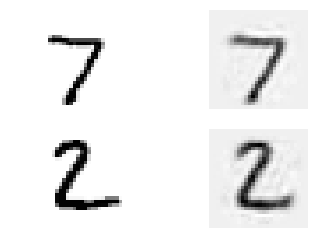

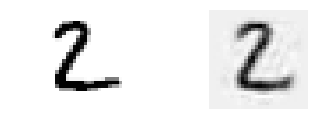

In [28]:
# for visualize
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])
    plt.show()

# Denoising Autoencoders

In [15]:
with tf.variable_scope("denoising_autoencoders", reuse=True):
    n_inputs = 28 * 28
    n_hidden1 = 300
    n_hidden2 = 150
    n_hidden3 = n_hidden1
    n_outputs = n_inputs
    learning_rate = 0.01
    l2_reg = 0.0001
    
    noise_level = 1.0

    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
    
    X_noise = X + noise_level * tf.random_normal(tf.shape(X))
    hidden1 = tf.layers.dense(X_noise, n_hidden1, activation=tf.nn.relu, name="hidden1")
    outputs = tf.layers.dense(hidden1, n_outputs)
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
    loss = reconstruction_loss
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(reconstruction_loss)
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        init.run()
        n_epochs = 5
        batch_size = 150
        for epoch in range(n_epochs):
            n_batches = mnist.train.num_examples // batch_size
            for iterations in range(n_batches):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                op_v, loss_v = sess.run([training_op, loss], feed_dict={X: X_batch})
                print("loss", loss_v)

('loss', 0.546974)
('loss', 0.36747739)
('loss', 0.19439593)
('loss', 0.13866627)
('loss', 0.11171357)
('loss', 0.12203625)
('loss', 0.12870547)
('loss', 0.11600287)
('loss', 0.1098101)
('loss', 0.13021915)
('loss', 0.10011745)
('loss', 0.1026578)
('loss', 0.093745671)
('loss', 0.090833455)
('loss', 0.092234001)
('loss', 0.097065493)
('loss', 0.095872514)
('loss', 0.084872283)
('loss', 0.081810907)
('loss', 0.082369909)
('loss', 0.09513066)
('loss', 0.076389432)
('loss', 0.080359422)
('loss', 0.16034548)
('loss', 0.073058628)
('loss', 0.071393013)
('loss', 0.14025883)
('loss', 0.082085378)
('loss', 0.068858787)
('loss', 0.073234834)
('loss', 0.075782031)
('loss', 0.076886952)
('loss', 0.071020044)
('loss', 0.068230107)
('loss', 0.071621723)
('loss', 0.072297662)
('loss', 0.070472032)
('loss', 0.083796516)
('loss', 0.070248373)
('loss', 0.065370828)
('loss', 0.082911193)
('loss', 0.067568704)
('loss', 0.079134852)
('loss', 0.069630049)
('loss', 0.069370665)
('loss', 0.095848516)
('loss'

('loss', 0.092873849)
('loss', 0.069080941)
('loss', 0.077674575)
('loss', 0.067071609)
('loss', 0.075293802)
('loss', 0.072623082)
('loss', 0.082186304)
('loss', 0.068855733)
('loss', 0.070489794)
('loss', 0.067859188)
('loss', 0.06813664)
('loss', 0.12120931)
('loss', 0.071132272)
('loss', 0.072298728)
('loss', 0.096422717)
('loss', 0.080695599)
('loss', 0.10336328)
('loss', 0.091447875)
('loss', 0.11973218)
('loss', 0.067338914)
('loss', 0.072943293)
('loss', 0.079373248)
('loss', 0.07995633)
('loss', 0.085042901)
('loss', 0.11702193)
('loss', 0.088024989)
('loss', 0.13907012)
('loss', 0.088285744)
('loss', 0.079334877)
('loss', 0.15061022)
('loss', 0.093850151)
('loss', 0.078489535)
('loss', 0.078373894)
('loss', 0.1487221)
('loss', 0.15194997)
('loss', 0.073612459)
('loss', 0.10996811)
('loss', 0.086622268)
('loss', 0.14166547)
('loss', 0.080465488)
('loss', 0.086119644)
('loss', 0.11372833)
('loss', 0.10943773)
('loss', 0.078025199)
('loss', 0.090642057)
('loss', 0.082743429)
('l

('loss', 0.12439052)
('loss', 0.091210738)
('loss', 0.095294014)
('loss', 0.20938919)
('loss', 0.22669646)
('loss', 0.13723695)
('loss', 0.095537312)
('loss', 0.14929412)
('loss', 0.40233776)
('loss', 0.20388106)
('loss', 0.22679518)
('loss', 0.10528941)
('loss', 0.13461208)
('loss', 0.35785002)
('loss', 0.13059869)
('loss', 0.095790699)
('loss', 0.087857008)
('loss', 0.22884606)
('loss', 0.08443103)
('loss', 0.24105455)
('loss', 0.090727404)
('loss', 0.25333759)
('loss', 0.078706451)
('loss', 0.45047233)
('loss', 0.82821327)
('loss', 0.085088521)
('loss', 0.25366679)
('loss', 0.093962587)
('loss', 0.19512771)
('loss', 0.2353107)
('loss', 0.1464722)
('loss', 0.17787658)
('loss', 0.25076729)
('loss', 0.1994811)
('loss', 0.10615993)
('loss', 0.10273983)
('loss', 0.12083463)
('loss', 0.11153886)
('loss', 0.10936168)
('loss', 0.42581046)
('loss', 0.17683181)
('loss', 0.11322964)
('loss', 0.19103143)
('loss', 0.084692031)
('loss', 0.080223523)
('loss', 0.13571721)
('loss', 0.13710994)
('los

('loss', 0.30204105)
('loss', 0.25493759)
('loss', 1.1353695)
('loss', 0.56132811)
('loss', 0.60004163)
('loss', 0.49611953)
('loss', 0.19331865)
('loss', 0.46854964)
('loss', 0.12747893)
('loss', 0.34682256)
('loss', 1.321238)
('loss', 0.52386177)
('loss', 0.2985256)
('loss', 0.2299787)
('loss', 0.20890284)
('loss', 0.56888747)
('loss', 0.26523331)
('loss', 0.31167603)
('loss', 0.5910992)
('loss', 0.22913022)
('loss', 1.0213064)
('loss', 0.23940304)
('loss', 0.71125352)
('loss', 0.40179563)
('loss', 0.16859762)
('loss', 0.14219484)
('loss', 0.29461575)
('loss', 0.18918248)
('loss', 0.50324816)
('loss', 0.27549306)
('loss', 0.48304018)
('loss', 0.69011998)
('loss', 0.28584385)
('loss', 0.11904978)
('loss', 0.16130349)
('loss', 0.22123516)
('loss', 0.46321177)
('loss', 0.1698796)
('loss', 0.45367283)
('loss', 0.16628227)
('loss', 0.16153844)
('loss', 2.0317833)
('loss', 0.65036637)
('loss', 0.22593696)
('loss', 0.12003084)
('loss', 0.25150394)
('loss', 0.717659)
('loss', 0.22323926)
('l

('loss', 0.16987319)
('loss', 0.21150315)
('loss', 0.17041281)
('loss', 0.1456923)
('loss', 0.16419952)
('loss', 0.14582369)
('loss', 0.14879517)
('loss', 0.35981685)
('loss', 0.22092977)
('loss', 0.20063871)
('loss', 0.12461393)
('loss', 0.098916523)
('loss', 0.20960143)
('loss', 0.51099688)
('loss', 0.15174572)
('loss', 0.13022888)
('loss', 0.31192422)
('loss', 0.1028322)
('loss', 0.16721454)
('loss', 0.25762859)
('loss', 0.085410774)
('loss', 0.16346399)
('loss', 0.13361867)
('loss', 0.31711298)
('loss', 0.11147697)
('loss', 0.37272069)
('loss', 0.19277161)
('loss', 0.19116424)
('loss', 0.10486407)
('loss', 0.76508957)
('loss', 0.096179679)
('loss', 0.16120669)
('loss', 0.25402862)
('loss', 0.12520012)
('loss', 0.087082133)
('loss', 0.5803352)
('loss', 0.28859454)
('loss', 0.19085857)
('loss', 0.15011476)
('loss', 0.091427758)
('loss', 0.12769467)
('loss', 0.20990624)
('loss', 0.086963944)
('loss', 0.36914811)
('loss', 0.13666798)
('loss', 0.26810029)
('loss', 0.1361115)
('loss', 0.

# Variational Autoencoders

In [21]:
n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

with tf.variable_scope("variational_autoencoders", reuse=tf.AUTO_REUSE):
    initializer = tf.contrib.layers.variance_scaling_initializer()
    my_dense_layer = partial(
        tf.layers.dense,
        activation=tf.nn.elu,
        kernel_initializer=initializer)

    X = tf.placeholder(tf.float32, [None, n_inputs])
    hidden1 = my_dense_layer(X, n_hidden1)
    hidden2 = my_dense_layer(hidden1, n_hidden2)
    hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
    hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
    noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
    hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
    hidden4 = my_dense_layer(hidden3, n_hidden4)
    hidden5 = my_dense_layer(hidden4, n_hidden5)
    logits = my_dense_layer(hidden5, n_outputs, activation=None)
    outputs = tf.sigmoid(logits)
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
    reconstruction_loss = tf.reduce_sum(xentropy)
    latent_loss = 0.5 * tf.reduce_sum(
        tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
    loss = reconstruction_loss + latent_loss

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    # show images
    n_digits = 60
    n_epochs = 50
    batch_size = 150
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = mnist.train.num_examples // batch_size
            for iteration in range(n_batches):
                X_batch, y_batch = mnist.train.next_batch(batch_size)
                sess.run(training_op, feed_dict={X: X_batch})

        codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
        outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})
        for iteration in range(n_digits):
            plt.subplot(n_digits, 10, iteration + 1)
            plot_image(outputs_val[iteration])

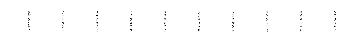

In [22]:
plt.show()